In [2]:
import numpy as np
import pandas as pd
from matplotlib import style
import matplotlib.pyplot as plt
import random
import torch
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import pickle
import copy
style.use("ggplot")

# 1. Pre-process dataset

In [3]:
## reading clean data
raw = pd.read_csv('cleaned-12-Oct.csv')
raw

StageName                     RecordType.Name RICE_Supported__c  \
0             0  Custom Education (MSPACE Included)          RIC-BD&I   
1             1                        Parent Grant          RIC-RE&D   
2             1                        Parent Grant          RIC-RE&D   
3             1                        Parent Grant     Not supported   
4             1                        Parent Grant          RIC-RE&D   
...         ...                                 ...               ...   
5403          1                   Research Contract          RIC-BD&I   
5404          0                     Competitive Bid          RIC-BD&I   
5405          1  Custom Education (MSPACE Included)          RIC-BD&I   
5406          1  Custom Education (MSPACE Included)          RIC-BD&I   
5407          1                   Research Contract          RIC-BD&I   

         Lead_Faculty__c      Lead_School__c  Parent_Opportunity__c  \
0     0012e000002ZGfbAAG  0012e000002Zt0mAAC                      0   
1               NotGiven            NotGiven                      0   
2               NotGiven            NotGiven                      0   
3               NotGiven            NotGiven                      0   
4               NotGiven            NotGiven                      0   
...                  ...                 ...                    ...   
5403  0012e000002ZGfbAAG  0012e000002Zt10AAC                      1   
5404            NotGiven            NotGiven                      0   
5405  0012e000002ZmnzAAC  0012e000002Z3p1AAC                      0   
5406  0012e000002ZmnzAAC  0012e000002Z3p1AAC                      0   
5407  0012e000002ZGfbAAG  0012e000002Zt0nAAC                      1   

                                   Industry  \
0                                    Health   
1                     Public Administration   
2                     Public Administration   
3                                    Health   
4                     Public Administration   
...                                     ...   
5403                                 Health   
5404  Construction & Construction Materials   
5405                               Services   
5406                               Services   
5407                                 Health   

                       Industry_Sub_Type__c  \
0               Health Care & Healthy Aging   
1                     Public Administration   
2                     Public Administration   
3               Health Care & Healthy Aging   
4                     Public Administration   
...                                     ...   
5403             Biotechnology (non-Pharma)   
5404  Construction & Construction Materials   
5405                              Education   
5406                              Education   
5407             Biotechnology (non-Pharma)   

                           Business_Type__c  Is_External__c  ParentId  \
0     Multinational / Other Large Corporate               1         0   
1            Government: Australia: Federal               1         1   
2            Government: Australia: Federal               1         1   
3            Government: Australia: Federal               1         0   
4            Government: Australia: Federal               1         1   
...                                     ...             ...       ...   
5403       SME (small to medium enterprise)               1         0   
5404                         Not for profit               1         0   
5405                             University               1         0   
5406                             University               1         0   
5407              Government: International               1         0   

      tasks_events  CreatedYear  CreatedMonth  year_length  \
0                0         2019            11            1   
1                0         2018             9           31   
2                0         2018             9            2   
3                0   

### (a) Over-sampling

In [4]:
raw["StageName"].value_counts(dropna=False)

0    3387
1    2021
Name: StageName, dtype: int64

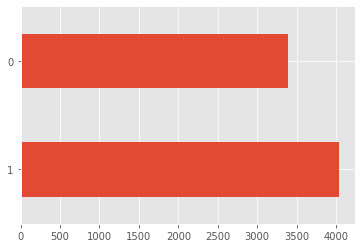

In [5]:
won_raw = raw[raw["StageName"]==1]
data = pd.concat([raw, won_raw], ignore_index=True)
data["StageName"].value_counts(dropna=False).plot(kind="barh")

### (b) feature selection

In [6]:
data = data.drop(['oppo_busi','fac_oppo','oppo_Industry',"year_length","RN","f_won_before"],axis=1)
data

StageName                     RecordType.Name RICE_Supported__c  \
0             0  Custom Education (MSPACE Included)          RIC-BD&I   
1             1                        Parent Grant          RIC-RE&D   
2             1                        Parent Grant          RIC-RE&D   
3             1                        Parent Grant     Not supported   
4             1                        Parent Grant          RIC-RE&D   
...         ...                                 ...               ...   
7424          1                   Research Contract          RIC-BD&I   
7425          1                   Research Contract          RIC-BD&I   
7426          1  Custom Education (MSPACE Included)          RIC-BD&I   
7427          1  Custom Education (MSPACE Included)          RIC-BD&I   
7428          1                   Research Contract          RIC-BD&I   

         Lead_Faculty__c      Lead_School__c  Parent_Opportunity__c  \
0     0012e000002ZGfbAAG  0012e000002Zt0mAAC                      0   
1               NotGiven            NotGiven                      0   
2               NotGiven            NotGiven                      0   
3               NotGiven            NotGiven                      0   
4               NotGiven            NotGiven                      0   
...                  ...                 ...                    ...   
7424  0012e000002ZGfbAAG  0012e000002Zt10AAC                      1   
7425  0012e000002ZGfbAAG  0012e000002Zt10AAC                      1   
7426  0012e000002ZmnzAAC  0012e000002Z3p1AAC                      0   
7427  0012e000002ZmnzAAC  0012e000002Z3p1AAC                      0   
7428  0012e000002ZGfbAAG  0012e000002Zt0nAAC                      1   

                   Industry         Industry_Sub_Type__c  \
0                    Health  Health Care & Healthy Aging   
1     Public Administration        Public Administration   
2     Public Administration        Public Administration   
3                    Health  Health Care & Healthy Aging   
4     Public Administration        Public Administration   
...                     ...                          ...   
7424                 Health                  Diagnostics   
7425                 Health   Biotechnology (non-Pharma)   
7426               Services                    Education   
7427               Services                    Education   
7428                 Health   Biotechnology (non-Pharma)   

                           Business_Type__c  Is_External__c  ParentId  \
0     Multinational / Other Large Corporate               1         0   
1            Government: Australia: Federal               1         1   
2            Government: Australia: Federal               1         1   
3            Government: Australia: Federal               1         0   
4            Government: Australia: Federal               1         1   
...                                     ...             ...       ...   
7424       SME (small to medium enterprise)               1         0   
7425       SME (small to medium enterprise)               1         0   
7426                             University               1         0   
7427                             University               1         0   
7428              Government: International               1         0   

      tasks_events  CreatedYear  CreatedMonth  
0                0         2019            11  
1                0         2018             9  
2                0         2018             9  
3                0         2019             2  
4                0         2017             4  
...            ...          ...           ...  
7424             0         2020             7  
7425             0         2020             7  
7426             0         2020             7  
7427             0         2020             7  
7428             0         2020             8  

[7429 rows x 14 columns]

## 1.2 One hot encoding

In [7]:
a = pd.get_dummies(data["RecordType.Name"], prefix='RecordType')
b = pd.get_dummies(data["RICE_Supported__c"], prefix='RICE_Supported')
c = pd.get_dummies(data["Lead_Faculty__c"], prefix='Lead_Faculty')
d = pd.get_dummies(data["Lead_School__c"], prefix='Lead_School')
e = pd.get_dummies(data["Industry"], prefix='Industry')
f = pd.get_dummies(data["Industry_Sub_Type__c"], prefix='Industry_Sub')
g = pd.get_dummies(data["Business_Type__c"], prefix='Business')
scale1 = data["CreatedYear"].div(2020)
scale2 = data["CreatedMonth"].div(12)
org = data[["StageName","Parent_Opportunity__c","Is_External__c","ParentId"]]

if 'year_length' in data.columns:
    scale3 = data["year_length"].div(31)
    scale4 = data["RN"].div(279)
    scale5 = data["f_won_before"]
    df = pd.concat([org,scale1,scale2,scale3,scale4,scale5,a,b,c,d,e,f,g], axis=1, ignore_index=True)

else:
    df = pd.concat([org,scale1,scale2,a,b,c,d,e,f,g], axis=1, ignore_index=True)

df

0    1    2    3         4         5    6    7    8    9    ...  141  \
0       0    0    1    0  0.999505  0.916667    0    0    0    1  ...    0   
1       1    0    1    1  0.999010  0.750000    0    0    0    0  ...    1   
2       1    0    1    1  0.999010  0.750000    0    0    0    0  ...    1   
3       1    0    1    0  0.999505  0.166667    0    0    0    0  ...    1   
4       1    0    1    1  0.998515  0.333333    0    0    0    0  ...    1   
...   ...  ...  ...  ...       ...       ...  ...  ...  ...  ...  ...  ...   
7424    1    1    1    0  1.000000  0.583333    0    0    0    0  ...    0   
7425    1    1    1    0  1.000000  0.583333    0    0    0    0  ...    0   
7426    1    0    1    0  1.000000  0.583333    0    0    0    1  ...    0   
7427    1    0    1    0  1.000000  0.583333    0    0    0    1  ...    0   
7428    1    1    1    0  1.000000  0.666667    0    0    0    0  ...    0   

      142  143  144  145  146  147  148  149  150  
0       0    0    0    1    0    0    0    0    0  
1       0    0    0    0    0    0    0    0    0  
2       0    0    0    0    0    0    0    0    0  
3       0    0    0    0    0    0    0    0    0  
4       0    0    0    0    0    0    0    0    0  
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  
7424    0    0    0    0    0    0    0    1    0  
7425    0    0    0    0    0    0    0    1    0  
7426    0    0    0    0    0    0    0    0    1  
7427    0    0    0    0    0    0    0    0    1  
7428    0    1    0    0    0    0    0    0    0  

[7429 rows x 151 columns]

In [8]:
# split xy
dflist = df.values.tolist()
x = torch.Tensor([i[1:] for i in dflist])
y = torch.Tensor([i[0] for i in dflist])

In [9]:
# train/dev split
#x_train, x_dev, y_train, y_dev = train_test_split(x, y, test_size=0.30, random_state=42)

In [54]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate

scoring_metrics = ["accuracy","precision","recall","f1","neg_log_loss"]
#neurons = [56,128,256,520,720,1024,2048,3072,4096]
neurons = [56,128]
results_neurons = {}

for i in neurons:
    clf = MLPClassifier(hidden_layer_sizes=(i,i,i,i),batch_size=64,max_iter=200)
    cv_score = cross_validate(estimator=clf, X=x, y=y, cv=10,scoring=scoring_metrics)
    
    results_neurons[i] = []
    for k,v in cv_score.items():
        results_neurons[i].append(v.mean())
        
    print(results_neurons[i])

/Users/huangraelene/opt/anaconda3/envs/tnsfl/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[23.22987244129181, 0.013808751106262207, 0.8134292026569636, 0.763816411385841, 0.955465102065762, 0.8484282356693011, -1.042475134899076]
[31.631463861465456, 0.022289490699768065, 0.8193614798315274, 0.7711945338572244, 0.9522601149003789, 0.8519480453342583, -1.1257096170636545]


In [55]:
results_columns = ['fit_time','score_time'] + ["accuracy","precision","recall","test_f1","neg_log_loss"]
results =  {56: [23.22987244129181, 0.013808751106262207, 0.8134292026569636, 0.763816411385841, 0.955465102065762, 0.8484282356693011, -1.042475134899076],
 128: [31.631463861465456, 0.022289490699768065, 0.8193614798315274, 0.7711945338572244, 0.9522601149003789, 0.8519480453342583, -1.1257096170636545],
 256: [64.65927577018738, 0.03256785869598389, 0.8255504202747657, 0.7769213372828926, 0.9557242390905756, 0.8568140855818175, -1.14597122484416],
 520: [217.71550931930543, 0.1000105857849121, 0.8220516373846829, 0.7744787656470684, 0.952260726072607, 0.8539436380453888, -1.0732707088328284],
 720: [455.5045162200928, 0.13085949420928955, 0.8227224082451488, 0.7751839949411072, 0.9522570590392372, 0.8543595921465006, -1.0892999671287698],
 1024: [617.3078515529633,
  0.21911213397979737,
  0.817745136095018,
  0.7747489844595402,
  0.9416202175773132,
  0.8495067646735505,
  -1.0780366980967746],
  2048: [1840.872208404541, 0.5915478229522705, 0.8065689471908521, 0.7614520529481474, 0.9418677423297884, 0.8417096376776178, -1.0536682220871687],
  3072: [4154.574123716355, 1.1990283012390137, 0.8184157255680148, 0.7742958900913458, 0.9428578413396895, 0.8500406547711462, -0.9516547992430542]
  }

In [60]:
print("neurons "+" ".join(["accuracy","precision","recall","test_f1","neg_log_loss"]))
for k,v in results.items():
    print(k,"\t",np.round(v[2:],4))

	accuracy precision recall test_f1 neg_log_loss
56 	 [ 0.8134  0.7638  0.9555  0.8484 -1.0425]
128 	 [ 0.8194  0.7712  0.9523  0.8519 -1.1257]
256 	 [ 0.8256  0.7769  0.9557  0.8568 -1.146 ]
520 	 [ 0.8221  0.7745  0.9523  0.8539 -1.0733]
720 	 [ 0.8227  0.7752  0.9523  0.8544 -1.0893]
1024 	 [ 0.8177  0.7747  0.9416  0.8495 -1.078 ]
2048 	 [ 0.8066  0.7615  0.9419  0.8417 -1.0537]
3072 	 [ 0.8184  0.7743  0.9429  0.85   -0.9517]


Text(0.5, 1.0, 'f1 plot')

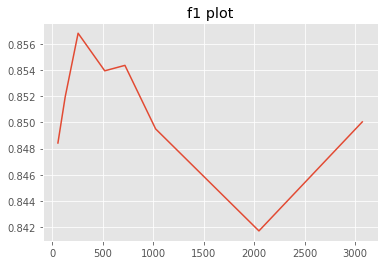

In [59]:
index = 5
vector = []
for k,v in results.items():
    vector.append(v[index])

plt.plot(list(results.keys()),vector)
plt.title(results_columns[index]+" plot")

['fit_time',
 'score_time',
 'accuracy',
 'precision',
 'recall',
 'f1',
 'neg_log_loss']
 
 {56: [6.599196720123291,
  0.008580255508422851,
  0.8021254983620711,
  0.7526217681788879,
  0.9510182129324043,
  0.839804296788369,
  -0.7003385221559623],
  
 128: [15.376729488372803,
  0.015903210639953612,
  0.8099374938781729,
  0.7648604633791974,
  0.9418677423297884,
  0.8438646713526768,
  -0.909877816792487],
  
 256: [31.145760941505433,
  0.02595553398132324,
  0.8104714985869915,
  0.763448779854478,
  0.9517601760176018,
  0.8463519107359563,
  -1.1568465069317793],
 
 520: [172.79028282165527,
  0.09201102256774903,
  0.8168011957061957,
  0.7703717855097878,
  0.9505225522552255,
  0.85036150715987,
  -1.0070152435993909],
  
 720: [368.74508633613584,
  0.17518937587738037,
  0.8169377804703739,
  0.7723103314578283,
  0.9433571690502383,
  0.8490442045305591,
  -1.0074423716846175],
  
 1024: [617.3078515529633,
  0.21911213397979737,
  0.817745136095018,
  0.7747489844595402,
  0.9416202175773132,
  0.8495067646735505,
  -1.0780366980967746],
  
  
  2048: [1840.872208404541, 0.5915478229522705, 0.8065689471908521, 0.7614520529481474, 0.9418677423297884, 0.8417096376776178, -1.0536682220871687],
  
  
  3072: [4154.574123716355, 1.1990283012390137, 0.8184157255680148, 0.7742958900913458, 0.9428578413396895, 0.8500406547711462, -0.9516547992430542]
  
  }

In [66]:
i = 2
scoring_metrics = ["accuracy","precision","recall","f1","neg_log_loss"]
neurons = 256
#results_layers = {}

clf = MLPClassifier(hidden_layer_sizes=(neurons,neurons,neurons),batch_size=64,max_iter=200)
cv_score = cross_validate(estimator=clf, X=x, y=y, cv=10,scoring=scoring_metrics)
    
results_layers[i] = []
for k,v in cv_score.items():
    results_layers[i].append(v.mean())
        
print(results_layers[i])

[69.58165378570557, 0.03073451519012451, 0.824880556351645, 0.7790948172889485, 0.9500311697836452, 0.8555915048211815, -1.0376296099924844]


In [ ]:
[27.938399839401246, 0.011365985870361328, 0.8119579688956767, 0.7703719674033026, 0.9349419386383083, 0.8442268061807618, -0.6435100212892836]
[89.22209923267364, 0.043657994270324706, 0.8235353868813327, 0.7749867927625644, 0.9554712137880454, 0.8554126756751664, -1.1326702630371348]




In [65]:
results_layers

{2: [89.22209923267364,
  0.043657994270324706,
  0.8235353868813327,
  0.7749867927625644,
  0.9554712137880454,
  0.8554126756751664,
  -1.1326702630371348]}

# other stuff

In [19]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(16,16),batch_size=64)
from sklearn.model_selection import cross_validate
cv_score = cross_validate(estimator=clf, X=x, y=y, cv=10,scoring=scoring_metrics)

/Users/huangraelene/opt/anaconda3/envs/tnsfl/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/huangraelene/opt/anaconda3/envs/tnsfl/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/huangraelene/opt/anaconda3/envs/tnsfl/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/huangraelene/opt/anaconda3/envs/tnsfl/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: S

{'fit_time': array([16.17299509, 16.16596293, 15.67140627, 14.26890707, 15.31652999,
       15.51007104, 14.54494119, 23.35909581, 29.65747929, 31.52311397]), 'score_time': array([0.01237297, 0.00808001, 0.00753093, 0.01047802, 0.00790191,
       0.0076189 , 0.00688481, 0.02273512, 0.00833988, 0.00721693]), 'test_neg_log_loss': array([-0.65540142, -0.46396144, -0.72391587, -0.69171047, -0.52503167,
       -0.53876829, -0.59762987, -0.77795845, -0.76345014, -1.0907716 ]), 'test_accuracy': array([0.79138627, 0.80349933, 0.74697174, 0.75100942, 0.74427995,
       0.79407806, 0.78061911, 0.71467026, 0.68102288, 0.69946092]), 'test_precision': array([0.74653465, 0.79318182, 0.72881356, 0.72121212, 0.73160173,
       0.76645435, 0.76957494, 0.68173258, 0.68918919, 0.69631236]), 'test_recall': array([0.93316832, 0.86386139, 0.85148515, 0.88366337, 0.83663366,
       0.89356436, 0.85148515, 0.89382716, 0.75555556, 0.79455446]), 'test_f1': array([0.82948295, 0.82701422, 0.78538813, 0.7942158 , 

/Users/huangraelene/opt/anaconda3/envs/tnsfl/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [17]:
def eval_metrics(outputs,labels):
    accuracy = torch.mean(torch.eq(outputs, labels).float()).item()

    target_true = torch.sum(labels == 1).float()
    predicted_true = torch.sum(outputs).float()
    correct_true = torch.sum(labels * outputs).float()

    recall = correct_true / target_true
    precision = correct_true / (predicted_true+0.00000000001)
    return accuracy,precision.cpu().item(),recall.cpu().item()

0.09588464545170447


/Users/huangraelene/opt/anaconda3/envs/tnsfl/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


(0.9613461494445801, 0.955501914024353, 0.9746657013893127)
(0.820547342300415, 0.8205128312110901, 0.8533333539962769)


/Users/huangraelene/opt/anaconda3/envs/tnsfl/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


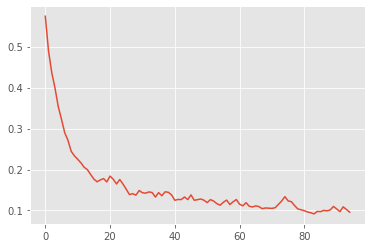

In [24]:
# fitting x_train & y_train
clf.fit(x_train, y_train)
train_pred = clf.predict(x_train)
print("training metrics: ", eval_metrics(torch.tensor(train_pred),torch.tensor(y_train)))
dev_pred = clf.predict(x_dev)
print("testing metrics: ", eval_metrics(torch.tensor(dev_pred),torch.tensor(y_dev)))
print(clf.loss_)
plt.plot(clf.loss_curve_)

In [23]:
print("hidden layers: (520,520,520,520)")
for k,v in cv_score.items():
    print(k,":\t",v.mean())

hidden layers: (520,520,520,520)
fit_time :	 249.65751852989197
score_time :	 0.08064439296722412
test_accuracy :	 0.8439888192764091
test_precision :	 0.7910325977910861
test_recall :	 0.9742665933259993


In [26]:
## (128 * 4)
print(cv_score)
print(cv_score.mean())

[0.8654105  0.90309556 0.83041723 0.82907133 0.85329744 0.85195155
 0.86271871 0.77119785 0.78196501 0.82210243]
0.8371227594112888


In [4]:
## (1024)
np.array([0.84253028, 0.89636608, 0.83445491, 0.82368775, 0.85733513,
       0.84522207, 0.86002692, 0.79004038, 0.76043069, 0.84770889]).mean()

0.83578031